In [1]:
import glob
from collections import defaultdict
from itertools import product

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import umap.umap_ as umap  # NOTE: must install umap-learn not umap
from networkx.drawing.nx_agraph import graphviz_layout
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform
from scripts import aesthetics, tree
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import colors
import palettable

aesthetics.activate_paper_rcParams()

import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Examine category hierarchy results

In this notebook, we'll begin the primary analysis of parsing through the CWAS results. This analysis needs to account for the fact that the categories themselves are hierarchical.

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

## Read in data

In [2]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


In [3]:
category_svs["value"] = 1

In [4]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [7]:
# for thing in framework_results.query('disease == "ewing" & sv_category == "coding" & bonferroni_significant')['category_name']:
#     print(thing)

Add some data to the framework results

In [8]:
framework_results["functional_category"] = framework_results["category_name"].apply(
    lambda c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
)

In [9]:
category_sizes = (
    category_svs.groupby(["category", "disease", "sv_category"])["value"]
    .sum()
    .reset_index()
    .rename(columns={"category": "category_name", "value": "num_svs_in_cat"})
)
framework_results = framework_results.merge(
    category_sizes, on=["category_name", "disease", "sv_category"], how="left"
)

## Filter the framework results a tad and add bonferroni

None of the gene groups are significant, and they significantly increase the size of the dataset, so I'm going to drop them.

In [10]:
p_val_cutoffs = {
    "neuroblastoma_coding": 0.05 / 279,
    "neuroblastoma_noncoding": 0.05 / 940,
    "ewing_coding": 0.05 / 267,
    "ewing_noncoding": 0.05 / 916,
}

framework_results["bonferroni_significant"] = framework_results.apply(
    lambda row: row["p_value"]
    < p_val_cutoffs[row["disease"] + "_" + row["sv_category"]],
    axis=1,
)

In [11]:
master_framework_results = framework_results.copy().set_index('category_name')

framework_results = framework_results[
    framework_results["category_name"].str.contains("protein_coding")
].copy()

In [12]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[f"{disease}_{sv_category}"] = data

# Examine hierarchy structure - Jaccard

The point here is as follows--there are 10 significant coding categories, and 67 significant non-coding categories.

I want to know how all these categories relate to each other. We can use the jaccard distance to do this.

In [13]:
nominally_sig_results = framework_results.query("p_value < 0.05")
nominally_sig_results.groupby(
    ["disease", "sv_category", "bonferroni_significant"]
).size()

disease        sv_category  bonferroni_significant
ewing          coding       False                      33
                            True                        8
               noncoding    False                     324
neuroblastoma  coding       False                      48
                            True                        8
               noncoding    False                     841
                            True                       26
dtype: int64

In [14]:
category_svs["value"] = 1

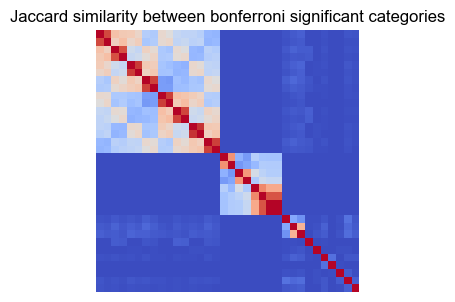

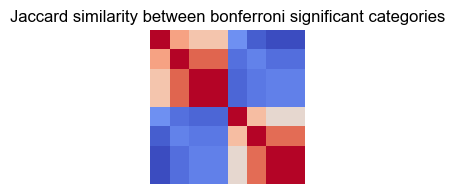

In [15]:
sv_category_matrix = {}
for disease in ["neuroblastoma", "ewing"]:
    nominal_categories = nominally_sig_results[
        nominally_sig_results["disease"] == disease
    ].query("bonferroni_significant")

    data = category_svs[
        (category_svs["disease"] == disease)
        & (category_svs["category"].isin(nominal_categories["category_name"].tolist()))
    ]

    data = data.pivot(columns="SV", index="category", values="value").fillna(0)
    sv_category_matrix[disease] = data

    data_values = data.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    Z = linkage(j_dist, method="average")
    ordered_indices = leaves_list(Z)
    j_dist = j_dist[ordered_indices, :][:, ordered_indices]
    j_dist = pd.DataFrame(
        j_dist, index=data.index[ordered_indices], columns=data.index[ordered_indices]
    )

    dim = np.max([data.shape[0] / 10, 2])
    fig, ax = plt.subplots(1, figsize=(dim, dim))
    sns.heatmap(j_dist, annot=False, cmap="coolwarm", cbar=False)
    aesthetics.strip_axis(ax=ax)

    ax.set_title(
        "Jaccard similarity between bonferroni significant categories", fontsize=12
    )
    fig.savefig(
        f"data/cwas-results/{disease}-jaccard-similarity-between-categories.png",
        bbox_inches="tight",
    )

In [16]:
# labels = {
#     "TAD boundary": [17, 8],
#     "H3K27Ac peak": [23, 19],
#     "Coding SVs": [33, 27],
#     "chromHMM15_EnhBiv": [37, 34],
#     "TAD boundary | CPGs": [39, 37],
#     "ABC max enhancer | promoter | adrenal": [42, 39.5],
#     "recombination hotspot | CPGs": [46, 43],
#     "ABC max enhancer": [52, 48],
#     "ATAC peaks conserved": [57, 53.5],
#     "ATAC peaks": [60, 57.5],
#     "? mix": [66, 62],
# }

# Explicitly plot the tree structure

Here, we'll plot the actual tree structure, since that's really what categories are (subsets of each other). To begin, we'll plot _entire trees_, for each disease and noncoding/coding splits.

Later in this notebook, we'll subset down to our significant categories and examine other questions of interest.

Note that handling functional categories is very annoying, as they are not related. So we have to break them up as well.

In [17]:
parent_dicts = {
    "coding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
    "noncoding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "functional_intersection": "ANY",
        "functional_category": "",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
}

In [18]:
noncoding_functional_categories = framework_schema["neuroblastoma_noncoding"][
    "functional_category"
].tolist()
noncoding_combos = list(
    product(["neuroblastoma", "ewing"], noncoding_functional_categories)
)
noncoding_combos = pd.DataFrame(
    noncoding_combos, columns=["disease", "functional_category"]
)
noncoding_combos["sv_category"] = "noncoding"

coding_combos = list(product(["neuroblastoma", "ewing"], [np.nan], ["coding"]))
coding_combos = pd.DataFrame(
    coding_combos, columns=["disease", "functional_category", "sv_category"]
)

combos = pd.concat([coding_combos, noncoding_combos])

In [21]:
for index, row in combos.iterrows():

    disease, func_cat, sv_category = row

    # if func_cat != "neuroblastoma_tad_boundary":
    #     continue

    # get the right category data
    subframework_results = framework_results.query(
        f'disease == "{disease}" & sv_category == "{sv_category}"'
    )

    if sv_category == "noncoding":
        subframework_results = subframework_results.query(
            f'functional_category == "{func_cat}"'
        )

    categories = subframework_results["category_name"].tolist()

    #########################################
    ### DEFINE THE CATEGORY RELATIONSHIPS ###
    #########################################

    parent_child_df = pd.DataFrame(0, index=categories, columns=categories)

    dg = nx.DiGraph()
    p_dict = parent_dicts[sv_category]

    for i, cat_i in enumerate(categories):
        for j, cat_j in enumerate(categories):
            parent_rel = tree.classify_relationship(cat_i, cat_j, p_dict)
            parent_child_df.iloc[i, j] = parent_rel

            if parent_rel and cat_i != cat_j:
                dg.add_edge(cat_i, cat_j)

    # do transitive reduction - ie removes "superparent" relationships
    dg = nx.transitive_reduction(dg)

    #############################
    ### DETERMINE NODE TRAITS ###
    #############################

    node_df = subframework_results.set_index("category_name").loc[list(dg.nodes)]

    # determine node positions
    pos = graphviz_layout(dg, prog="dot")  # , args='-Grankdir=LR')

    # and determine node size
    node_size = node_df["point_estimate"]
    node_pvals = node_df["negative_log10_p_value"]

    # make node colors
    norm = mpl.colors.Normalize(
        vmin=0, vmax=round(node_size[node_df["bonferroni_significant"]].max(), 1)
    )
    cmap_reds = plt.cm.Reds

    node_colors = []
    for i in range(len(node_size)):
        size = node_size.iloc[i]
        bonf = node_df["bonferroni_significant"].iloc[i]

        if not bonf:
            node_colors.append("lightgrey")
        else:
            node_colors.append(cmap_reds(norm(size)))

    fig, ax = plt.subplots(1, figsize=(16, 8))
    nx.draw(
        dg,
        with_labels=False,
        ax=ax,
        pos=pos,
        arrows=False,
        edge_color="lightgrey",
        node_size=node_size * 80,
        node_color=node_colors,
        width=0.2,
    )

    fig.suptitle(f"{disease}: {func_cat}", y=0.85)

    out_name = f"{disease}-{sv_category}"
    if sv_category == "noncoding":
        out_name += f"-{func_cat}"

    fig.savefig(
        f"data/cwas-results/category-hierarchies/{out_name}-tree.png",
        bbox_inches="tight",
    )

    plt.close(fig)

## Try a radically different approach

I'm noticing that the tree structure is a little bit odd. While it's true, it's unexpected that nodes can have multiple parents, and you can get "high level" nodes that are quite large depending on the restrictions.

I think what is _more intuitive_ is that the y position on the plot varies by the number of SVs in the category. Let's try something like this.

In [22]:
# label_dict = {
#     "noncoding | neuroblastoma_tad_boundary": [
#         [
#             "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
#             "DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
#             "DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
#             "DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
#             "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
#             "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.lof_constrained.expressed_in_adrenal_gland.protein_coding",
#         ],
#         [
#             "Singleton\nSVs",
#             "Deletions",
#             "Expressed\nin adrenal",
#             "Intergenic",
#             "Noncoding\nbreakpoint",
#             "LOF\nconstrained"
#         ]
#     ]
# }

# largest effect size
# label_dict = {
#     "noncoding | neuroblastoma_tad_boundary": [
#         [
#             "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
#             "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding",
#             "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
#             "DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
#             "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
#             "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.lof_constrained.expressed_in_adrenal_gland.protein_coding",
#         ],
#         [
#             "Singleton\nSVs",
#             "Intergenic",
#             "Expressed\nin adrenal",
#             "Deletions",
#             "Noncoding\nbreakpoint",
#             "LOF\nconstrained"
#         ]
#     ]
# }

# most significant path
label_dict = {
    "noncoding | neuroblastoma_tad_boundary": [
        [
            "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
            "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding",
            "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding",
            "ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
            "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding",
            "DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.lof_constrained.expressed_in_adrenal_gland.protein_coding",
        ],
        [
            "Singleton\nSVs",
            "Intergenic",
            "Expressed\nin adrenal",
            "Deletions",
            "Noncoding\nbreakpoint",
            "LOF\nconstrained"
        ]
    ]
}

In [23]:
import matplotlib

In [24]:
for index, row in combos.iterrows():

    #############################
    ### EXTRACT RELEVANT DATA ###
    #############################

    disease, func_cat, sv_category = row

    # if func_cat != "neuroblastoma_tad_boundary":
    #     continue

    # get the right category data
    subframework_results = framework_results.query(
        f'disease == "{disease}" & sv_category == "{sv_category}" & af_category == "singleton"'
    )

    if sv_category == "noncoding":
        subframework_results = subframework_results.query(
            f'functional_category == "{func_cat}"'
        )

    # remove nodes with negative point estimates
    subframework_results = subframework_results.query("point_estimate > 0")

    categories = subframework_results["category_name"].tolist()

    if len(categories) < 2:
        continue

    ###########################################
    ### DEFINE DISTANCES BETWEEN CATEGORIES ###
    ###########################################

    data = category_svs[
        (category_svs["disease"] == disease)
        & (category_svs["category"].isin(categories))
        & (category_svs["sv_category"] == sv_category)
    ]

    data = data.pivot(columns="SV", index="category", values="value").fillna(0)
    data_values = data.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    j_dist = pd.DataFrame(j_dist, index=data.index, columns=data.index)

    #########################################
    ### DEFINE THE CATEGORY RELATIONSHIPS ###
    #########################################

    dg = nx.DiGraph()
    p_dict = parent_dicts[sv_category]

    for i, cat_i in enumerate(categories):
        for j, cat_j in enumerate(categories):
            parent_rel = tree.classify_relationship(cat_i, cat_j, p_dict)

            if parent_rel and cat_i != cat_j:
                dg.add_edge(cat_i, cat_j, weight=j_dist.loc[cat_i, cat_j])

    # do transitive reduction - ie removes "superparent" relationships
    dg = nx.transitive_reduction(dg)

    ################################
    ### DETERMINE NODE POSITIONS ###
    ################################

    node_df = subframework_results.set_index("category_name").loc[list(dg.nodes)]

    # determine initial node positions based on hierarchy
    node_positions = graphviz_layout(
        dg, prog="dot", args="-start=42"
    )

    # redetermine node positions based on force
    force_positions = nx.spring_layout(dg, pos=node_positions, seed=42)

    # reset the x position depending category similarity.
    for cat, pos in node_positions.items():
        pos = (force_positions[cat][0], pos[1])
        node_positions[cat] = pos

    # if we're on neuroblastoma tad boundaries, edit some points
    if func_cat == "neuroblastoma_tad_boundary" and disease == "neuroblastoma":
        for cat, pos in node_positions.items():
            if pos[0] > 0.5:
                node_positions[cat] = [pos[0] - 0.15, pos[1]]

    # before we trim or tighten the tree, store it for future reference
    master_node_df = node_df.copy()
    master_node_df[["x", "y"]] = [node_positions[cat] for cat in master_node_df.index]

    #######################################
    ### TRIM TREE BY JACCARD SIMILARITY ###
    #######################################

    bonf_cats = list(node_df.query("bonferroni_significant").index)
    dg, node_positions = tree.trim_tree_by_similarities(
        dg, node_df, node_positions, bonf_cats, j_dist, 0.4, "negative_log10_p_value", axis = 'y'
    )

    # remove nodes from our data based on this process
    kept_nodes = list(dg.nodes)
    node_df = node_df.loc[kept_nodes]

    #########################
    ### TIGHTEN THE GRAPH ###
    #########################

    dg, node_positions = tree.tighten_tree(
        dg, node_df, node_positions, 0.02, "negative_log10_p_value", axis = 'x'
    )

    # drop to these nodes and recreate positions
    kept_nodes = list(dg.nodes)
    node_df = node_df.loc[kept_nodes]

    ############################################
    ### DETERMINE OTHER NODE CHARACTERISTICS ###
    ############################################

    # and determine node size
    node_size = np.sqrt(node_df["num_svs_in_cat"])
    node_eff = node_df["point_estimate"]

    # make node colors
    norm = mpl.colors.Normalize(
        vmin=0.25,
        vmax=0.60,
    )
    
    purple = '#9D4DAD'
    custom_cmap = colors.LinearSegmentedColormap.from_list('custom_purple', ['gainsboro', purple], N = 256)

    node_colors = []
    border_sizes = []
    for i in range(len(node_eff)):
        eff = node_eff.iloc[i]
        bonf = node_df["bonferroni_significant"].iloc[i]
        pval = node_df["p_value"].iloc[i]
        
        if pval > 0.05:
            node_colors.append("gainsboro")
        else:
            node_colors.append(custom_cmap(norm(eff)))

        # # determine the border size
        if bonf:
            border_sizes.append(0.5)
        else:
            border_sizes.append(0)

    node_colors = pd.Series(node_colors, index=node_df.index)
    border_sizes = pd.Series(border_sizes, index=node_df.index)

    #####################
    ### PLOT THE TREE ###
    #####################

    fig = plt.figure(figsize=(2, 6), tight_layout=False)
    gs = fig.add_gridspec(2, 1, hspace=0, height_ratios=[3, 1])

    ax = fig.add_subplot(gs[0])

    # create a variable for plotting level
    node_df["plot_level"] = 0
    sorted_sig_cats = node_df.query("bonferroni_significant").sort_values(
        by="negative_log10_p_value"
    )
    node_df.loc[sorted_sig_cats.index, "plot_level"] = list(
        range(1, len(sorted_sig_cats) + 1)
    )

    # plot nodes separately to allow zorder control
    for zorder in node_df["plot_level"].unique():
        cats = node_df[node_df["plot_level"] == zorder].index
        sub_dg = dg.subgraph(cats)
        sub_pos = {node: val for node, val in node_positions.items() if node in cats}
        sub_colors = node_colors.loc[cats]
        sub_sizes = node_size.loc[cats]
        sub_borders = border_sizes.loc[cats]

        collection = nx.draw_networkx_nodes(
            sub_dg,
            pos=sub_pos,
            node_color=sub_colors,
            node_size=sub_sizes * 1.25,
            edgecolors="black",
            linewidths=sub_borders,
            ax=ax,
        )
        collection.set_zorder(zorder)

    edge_collection = nx.draw_networkx_edges(
        dg, pos=node_positions, edge_color="lightgrey", width=0.1, arrows=False, ax=ax
    )
    edge_collection.set_zorder(-1)
    
    # label the "y axis"
    aesthetics.strip_axis(ax = ax)
    
    # add the colorbar
    if func_cat == "neuroblastoma_tad_boundary":
        cb = matplotlib.cm.ScalarMappable(norm=norm, cmap=custom_cmap)

        cbar_ax = fig.add_axes([0, 0.6, 0.03, 0.2])
        cbar = fig.colorbar(cb, cax=cbar_ax, orientation='vertical')

        cbar.ax.tick_params(size=0)
        cbar.set_ticklabels([])
        cbar.outline.set_visible(False)

        # create an axis for other labels
        point_labels = fig.add_axes([0, 0.4, 0.1, 0.15])
        point_labels.scatter([0, 0, 0], [0, 0.5, 1], 
                             s = [10 * 1.25, np.sqrt(1000) * 1.25, np.sqrt(3000) * 1.25], 
                             color = 'darkgrey', ec = None)
        point_labels.set_ylim([-0.25, 1.25])
        aesthetics.strip_axis(ax = point_labels)

    ###################
    ### LABEL PATHS ###
    ###################
    
    title = sv_category + ' | ' + str(func_cat)
    if title in label_dict:
        nodes, labels = label_dict[title]
        subgraph = dg.subgraph(nodes)
        subpos = {k: v for k, v in node_positions.items() if k in nodes}
        
        # draw the edges using annotate
        prev_node = nodes[0]
        for n in nodes[1:]:
            source_pos = np.array(node_positions[prev_node])
            target_pos = np.array(node_positions[n])
            
            ax.annotate("",
            xytext=source_pos, xycoords='data',
            xy=target_pos, textcoords='data',
            arrowprops=dict(color='black', 
                            headlength=2,
                            headwidth=2,
                            lw=0.5,
                            width=0.1,
                            shrink=0.2)
                       )
            
            prev_node = n
                
    ###################
    ### SAVE FIGURE ###
    ###################

    out_name = f"{disease}-{sv_category}"
    if sv_category == "noncoding":
        out_name += f"-{func_cat}"

    # fig.suptitle(f"{disease}: {func_cat}", y=0.9, fontsize=10)
    fig.savefig(
        f"data/cwas-results/category-hierarchies/{out_name}-tree-scaled.pdf",
        bbox_inches="tight",
    )

    plt.close(fig)

## Plot change in effect size for path

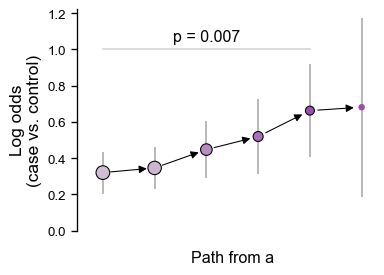

In [70]:
fig, ax = plt.subplots(1, figsize = (4, 3))
labeled_nodes, labeled_paths = label_dict[title]

labeled_node_df = framework_results.set_index('category_name').loc[labeled_nodes].reset_index()
labeled_node_df['size'] = np.sqrt(labeled_node_df['num_svs_in_cat']) * 2
labeled_node_df['color'] = [custom_cmap(norm(eff)) for eff in labeled_node_df['point_estimate']]
labeled_node_df = labeled_node_df.drop_duplicates()

ax.errorbar(x = range(len(labeled_node_df)), y = labeled_node_df['point_estimate'],
            yerr = 2 * labeled_node_df['std_error'], ecolor = 'darkgrey', fmt='none', zorder = 0)

# plot the bonferroni and non-bonferroni points
bonf_df = labeled_node_df.query('bonferroni_significant == True')
ax.scatter(x = bonf_df.index, y = bonf_df['point_estimate'], color = bonf_df['color'],
           s = bonf_df['size'], ec = 'black')

non_bonf_df = labeled_node_df.query('bonferroni_significant == False')
ax.scatter(x = non_bonf_df.index, y = non_bonf_df['point_estimate'], color = non_bonf_df['color'],
           s = non_bonf_df['size'], ec = None)

ax.set_xticks(range(len(labeled_node_df)))
ax.set_xticklabels([])
ax.set_xlabel('')
aesthetics.strip_axis(ax, x = 'label', y = 'ignore')
ax.set_ylim([0, None])
ax.set_xlim([-0.5, None])

ymax = ax.get_ylim()[1]
ax.spines['left'].set_bounds([0, ymax])
ax.set_ylabel('Log odds\n(case vs. control)')

ax.plot([0, 4], [1, 1], color = 'lightgrey')
ax.text(s = 'p = 0.007', x = 2, y = 1.03, ha = 'center', va = 'bottom')

ax.text(s = 'Path from a', x = 2.5, y = -0.15, ha = 'center', va = 'center')

prev_index = 0
prev_y = labeled_node_df.iloc[0]['point_estimate']
for i, (_, row) in enumerate(labeled_node_df.iloc[1:, :].iterrows()):
    curr_y = row['point_estimate']
    
    slope = (curr_y - prev_y)
    
    bbox = ax.annotate("",
            xytext=(i + 0.1, prev_y + slope * 0.1), xycoords='data',
            xy=(i + 0.9, curr_y - slope * 0.1), textcoords='data',
            arrowprops=dict(arrowstyle="-|>",
                            connectionstyle="arc3", color='black'),
            )
    
    prev_y = curr_y
    
fig.savefig('images/labelled-path-tads.png', bbox_inches = 'tight')

## Plot the change in effect size for this path

In [39]:
tad_boundaries = framework_results.query(
    'disease == "neuroblastoma" & sv_category == "noncoding" & functional_category == "neuroblastoma_tad_boundary" & af_category == "singleton"'
)

In [40]:
label_dict = {
            "Singleton\nSVs": ".SINGLETON.",
            "Deletions": "DEL.",
            "Expressed in\nadrenal tissue": '.expressed_in_adrenal_gland.',
            "Intergenic": 'PREDICTED_INTERGENIC',
            "Noncoding\nbreakpoint": '.PREDICTED_NONCODING_BREAKPOINT.',
            "LOF\nconstrained": '.lof_constrained.',
            "COSMIC and\ngermline CPGs": 'cosmic_and_germline_CPGs'
}

In [41]:
swarm_df = []
for index, row in tad_boundaries.iterrows():
    cat = row['category_name']
    point_est = row['point_estimate']
    p = row['p_value']
    logp = row['negative_log10_p_value']
    std = row['std_error']
    
    base_row = [cat, point_est, std, p, logp]
    
    for label, string in label_dict.items(): 
        if string in cat:
            swarm_df.append(base_row + [label])
            
swarm_df = pd.DataFrame(swarm_df, columns = ['category_name', 'point_est', 'std_error', 'p_value', 'negative_log10_p_value', 'restriction'])

In [42]:
means = swarm_df.query('point_est > -3').groupby(['restriction'])['point_est'].mean().reset_index()
order = means.sort_values(by = 'point_est', ascending = False)['restriction'].tolist()

Text(0, 0.5, 'point estimate')

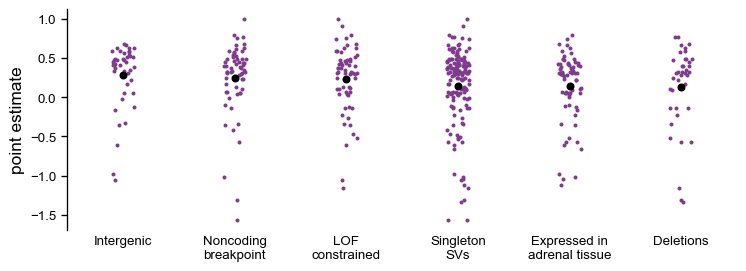

In [43]:
fig, ax = plt.subplots(1, figsize = (9, 3))

sns.stripplot(x = 'restriction', y = 'point_est', data = swarm_df.query('point_est > -3'), order = order, s = 3)
ax.set_xlabel('')
aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')

means = swarm_df.query('point_est > -3').groupby(['restriction'])['point_est'].mean().reset_index()
sns.stripplot(x = 'restriction', y = 'point_est', data = means, order = order, color = 'black', s = 6)
ax.set_xlabel('')
ax.set_ylabel('point estimate')

In [44]:
swarm_df['1 / var_error'] = 1 / (swarm_df['std_error'] ** 2)
swarm_df['weighted_point_est'] = swarm_df['point_est'] * swarm_df['1 / var_error']

In [45]:
mean_df = pd.DataFrame(swarm_df.groupby(['restriction']).apply(lambda g: (g['weighted_point_est'].sum() / g['1 / var_error'].sum()))).reset_index().rename(columns = {0: 'mean'})
std_df = pd.DataFrame(swarm_df.groupby(['restriction']).apply(lambda g: np.sqrt(1 /  g['1 / var_error'].sum()))).reset_index().rename(columns = {0: 'std'})

stat_df = mean_df.merge(std_df).sort_values(by = 'mean', ascending = False)


In [46]:
# ref_cat = 'ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding'
# mean = framework_results.set_index('category_name').loc[ref_cat, 'point_estimate']
# std = framework_results.set_index('category_name').loc[ref_cat, 'std_error']
# ref_row = pd.DataFrame([['No restriction', mean, std]], columns = ['restriction', 'mean', 'std'])

# stat_df = pd.concat([ref_row, stat_df])

ValueError: 'x' and 'y' must have the same size

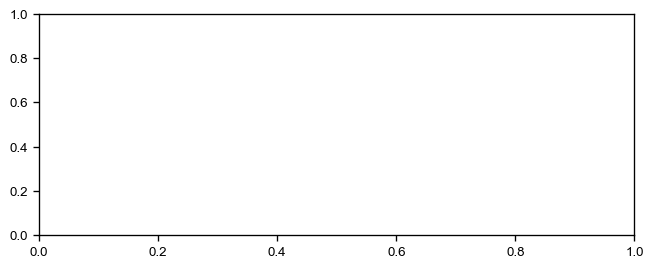

In [47]:
fig, ax = plt.subplots(1, figsize = (8, 3))

ax.errorbar(x = list(range(7)), y = list(stat_df['mean']),
            yerr = list(2 * stat_df['std']), ecolor = 'black', fmt='none', zorder = 0)

sns.scatterplot(x = 'restriction', y = 'mean', data = stat_df, s = 40, zorder = 1, ec = None)
# ax.set_ylim([0, 0.4])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4]);
aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')
ax.set_xlim([-0.5, None])
ax.set_ylabel('Mean category\nodds-ratio')
ax.set_xlabel('')
ax.set_title('TAD-boundary categories')

fig.savefig('images/mean-category-odds-ratio-tads.png', dpi = 300)

## Try a subtraction framework

In [ ]:
parent_dicts = {
    "coding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
    "noncoding": {
        "sv_type": "ANY",
        "frequency": "RARE",
        "functional_intersection": "ANY",
        "functional_category": "",
        "genic_relationship": "ANY",
        "constraint": "ANY",
        "expression": "ANY",
        "gene_group": "protein_coding",
    },
}

children_dicts = {"coding": {}, "noncoding": {}}

# build the child dict
for sv_category in ['coding', 'noncoding']:
    schema = framework_schema[f'neuroblastoma_{sv_category}']
    
    for col in schema.columns:
        par = parent_dicts[sv_category][col]
        children = [val for val in schema[col].dropna() if val != par]
        children_dicts[sv_category][col] = children
        
noncoding_components = list(framework_schema[f'neuroblastoma_noncoding'].columns)

Now let's build this thing

In [ ]:
tad_boundaries = tad_boundaries.set_index('category_name')

In [ ]:
cat_subtraction_df = []

for cat, row in tad_boundaries.iterrows():
    point_est = row['point_estimate']
    std_error = row['std_error']
    
    cat_components = dict(zip(noncoding_components, cat.split('.')))
    
    for comp, value in cat_components.items():
        if comp == 'functional_category':
            continue

        par = parent_dicts["noncoding"][comp]
        children = children_dicts["noncoding"][comp]
        
        if value != par:
            continue
            
        new_cat = cat_components.copy()
            
        # check to see if the immediate children are in our results
        for child in children:
            new_cat[comp] = child
            new_cat_string = '.'.join(new_cat.values())
            
            if new_cat_string not in tad_boundaries.index:
                continue
            
            new_point_est = tad_boundaries.loc[new_cat_string, 'point_estimate']
            new_std_error = tad_boundaries.loc[new_cat_string, 'std_error']
            
            row = [cat, new_cat_string, comp, child, new_point_est - point_est, std_error + new_std_error]
            cat_subtraction_df.append(row)
                
cat_subtraction_df = pd.DataFrame(cat_subtraction_df, 
                                  columns = ['category_name', 'child_category_name', 'component', 'child_component', 
                                             'point_est_diff', 'std_error'])

In [ ]:
label_dict = {'SINGLETON': 'Singleton\nSVs',
 'DEL': 'Deletions',
 'expressed_in_adrenal_gland': 'Expressed in\nadrenal tissue',
 'PREDICTED_INTERGENIC': 'Intergenic',
 'PREDICTED_NONCODING_BREAKPOINT': 'Noncoding\nbreakpoint',
 'lof_constrained': 'LOF\nconstrained',
 'cosmic_and_germline_CPGs': 'COSMIC and\ngermline CPGs'}

In [ ]:
component_stat_df = cat_subtraction_df[cat_subtraction_df['child_component'].isin(label_dict.keys())]
component_stat_df['1 / var_error'] = 1 / (component_stat_df['std_error'] ** 2)
component_stat_df['weighted_point_est_diff'] = component_stat_df['point_est_diff'] * component_stat_df['1 / var_error']

In [ ]:
all(['SINGLETON' in s for s in tad_boundaries.index])

In [36]:
mean_df = pd.DataFrame(component_stat_df.groupby(['child_component']).apply(lambda g: (g['weighted_point_est_diff'].sum() / g['1 / var_error'].sum()))).reset_index().rename(columns = {0: 'mean'})
std_df = pd.DataFrame(component_stat_df.groupby(['child_component']).apply(lambda g: np.sqrt(1 /  g['1 / var_error'].sum()))).reset_index().rename(columns = {0: 'std'})

stat_df = mean_df.merge(std_df).sort_values(by = 'mean', ascending = False)
stat_df['restriction'] = stat_df['child_component'].replace(label_dict)

NameError: name 'component_stat_df' is not defined

In [ ]:
stat_df

In [ ]:
fig, ax = plt.subplots(1, figsize = (8, 3))


ax.errorbar(x = range(len(stat_df)), y = list(stat_df['mean']),
            yerr = list(2 * stat_df['std']), ecolor = 'black', fmt='none', zorder = 0)

sns.scatterplot(x = 'restriction', y = 'mean', data = stat_df, s = 40, zorder = 1, ec = None)

# ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4]);
aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')
ax.set_xlim([-0.5, None])
ax.set_ylabel('Mean added\nodds-ratio')
ax.set_xlabel('')
ax.set_title('TAD-boundary categories')
ax.axhline(y = 0, linestyle = 'dashed', color = 'darkgrey')
ax.set_ylim([-0.3, 0.3])

fig.savefig('images/mean-added-category-odds-ratio-tads.png', dpi = 300)

In [ ]:
framework_schema['neuroblastoma_noncoding'].head(6)

In [17]:
ref_cats = ['ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding', 
            'DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding',
            'DEL.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.lof_constrained.expressed_in_adrenal_gland.protein_coding']

ref_result = framework_results.set_index('category_name').loc[ref_cats]

test = component_stat_df.query(f'category_name == "{ref_cat}"')
test_children = framework_results.merge(test[['child_category_name', 'child_component']], 
                                        left_on = ['category_name'], right_on = ['child_category_name'])
test_children = pd.concat([test_children, ref_result.reset_index()])

test_children.iloc[-3, -1] = 'Reference\n(All TAD singletons)'
test_children.iloc[-2, -1] = 'Deepest significant\ncategory'
test_children.iloc[-1, -1] = 'Deepest nominal\ncategory'

test_children['restriction'] = test_children['child_component'].replace(label_dict)

test_children = test_children.set_index('restriction').sort_values(by = 'point_estimate', ascending = False)

order = ['Reference\n(All TAD singletons)',
 'Intergenic',
 'Deletions',
 'Expressed in\nadrenal tissue',
 'Noncoding\nbreakpoint',
 'Deepest significant\ncategory',
 'Deepest nominal\ncategory',
 'LOF\nconstrained',
 'COSMIC and\ngermline CPGs']

test_children = test_children.loc[order].reset_index()

NameError: name 'component_stat_df' is not defined

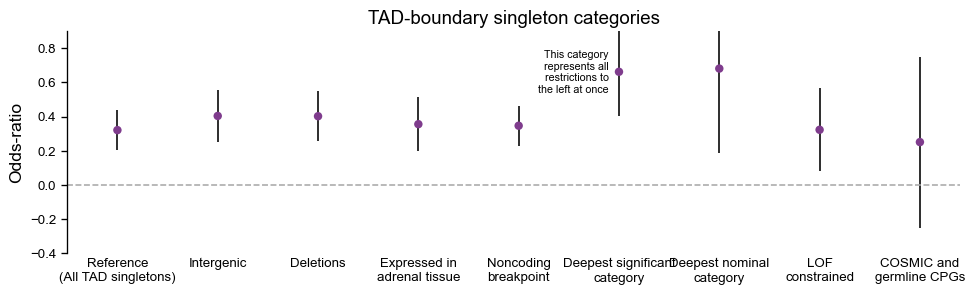

In [253]:
fig, ax = plt.subplots(1, figsize = (12, 3))

ax.errorbar(x = range(len(test_children)), y = list(test_children['point_estimate']),
            yerr = list(2 * test_children['std_error']), ecolor = 'black', fmt='none', zorder = 0)

sns.scatterplot(x = 'restriction', y = 'point_estimate', data = test_children, s = 40, ec = None)
ax.set_ylim([-0.4, 0.9])

aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')
ax.set_xlim([-0.5, None])
ax.set_ylabel('Odds-ratio')
ax.set_xlabel('')
ax.set_title('TAD-boundary singleton categories')
ax.axhline(y = 0, linestyle = 'dashed', color = 'darkgrey')
ax.text(s = 'This category\nrepresents all\nrestrictions to\nthe left at once', x = 4.9, y = 0.66, 
        ha = 'right', va = 'center', fontsize = 8)

fig.savefig('images/mean-added-category-odds-ratio-tads.png', dpi = 300)

## TADs

In [174]:
tad_boundaries = framework_results.query(
    'disease == "neuroblastoma" & sv_category == "noncoding" & functional_category == "neuroblastoma_tad_boundary" & p_value < 0.05 & point_estimate > 0'
)["category_name"].tolist()

In [175]:
len(tad_boundaries)

69

In [188]:
# 1 if row is parent of column. Also make a graph concurrently.
dg = nx.DiGraph()

for i, cat_i in enumerate(tad_boundaries):
    for j, cat_j in enumerate(tad_boundaries):
        parent_rel = tree.classify_relationship(cat_i, cat_j, parent_dicts["noncoding"])

        if parent_rel and cat_i != cat_j:
            dg.add_edge(cat_i, cat_j)

# do transitive reduction - ie removes "superparent" relationships
dg = nx.transitive_reduction(dg)

In [189]:
# next, we do some math on the tree to identify our node "levels"
overall_parent_node = [node for node in dg.nodes if dg.in_degree(node) == 0]
assert len(overall_parent_node) == 1

overall_parent_node = overall_parent_node[0]

# for each node, determine how far away it is from the overall parent
node_levels = {
    node: len(nx.shortest_path(dg, source=overall_parent_node, target=node)) - 1
    for node in dg.nodes
}
nx.set_node_attributes(dg, node_levels, "level")

node_level_df = pd.DataFrame.from_dict(node_levels, orient="index", columns=["level"])

# calculate some y values
num_depth = node_level_df["level"].value_counts()

yvals = []
for depth in range(node_level_df["level"].max() + 1):
    depth_y = np.arange(0, 1, 1 / num_depth.loc[depth])
    yvals += list(depth_y)

node_level_df["y"] = yvals
node_level_df["effect_size"] = (
    framework_results.query('disease == "neuroblastoma"')
    .set_index("category_name")
    .loc[list(node_level_df.index), "point_estimate"]
    .values
)

node_level_df = node_level_df.loc[list(dg.nodes)]

In [190]:
# determine node positions
pos = graphviz_layout(dg, prog="dot", args="-Grankdir=LR")

# and determine node size
node_size = framework_results.set_index("category_name").loc[
    tad_boundaries, "num_svs_in_cat"
]

# make node colors
norm = mpl.colors.Normalize(
    vmin=round(node_level_df["effect_size"].min(), 1),
    vmax=round(node_level_df["effect_size"].max(), 1),
)
cmap = plt.cm.Greens
colors = [cmap(norm(val)) for val in node_level_df["effect_size"]]

In [192]:
from matplotlib import cm

Text(0.5, 0, 'effect size')

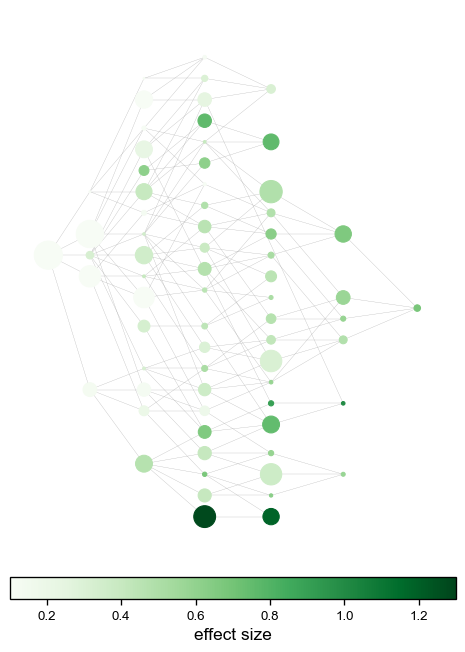

In [193]:
fig, ax = plt.subplots(1, figsize=(6, 8))
nx.draw(
    dg,
    with_labels=False,
    ax=ax,
    pos=pos,
    arrows=False,
    node_size=node_size / 10,
    node_color=colors,
    edge_color="darkgrey",
    width=0.2,
)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="Greens"),
    ax=ax,
    fraction=0.04,
    orientation="horizontal",
    pad=0.02,
)
cbar.ax.set_xlabel("effect size")
# fig.savefig('data/cwas-results/example-tad-boundary-effect-sizes.png', bbox_inches = 'tight')

# Coding effects

In [415]:
coding_categories = nbl_analysis_categories.query(
    'sv_category == "coding" & negative_log10_p_value > 3.5'
)["category_name"].tolist()

In [419]:
coding_subcharacteristics = {
    "sv_type": "ANY",
    "frequency": "RARE",
    "genic_relationship": "ANY",
    "constraint": "ANY",
    "expression": "ANY",
    "gene_group": "",
}

In [420]:
def classify_coding_relationship(cat_i, cat_j):
    cat_i_components = cat_i.split(".")
    cat_j_components = cat_j.split(".")

    # dicts are ordered in python 3.7
    subparents = []
    for cat, c_i, c_j in zip(
        coding_subcharacteristics.keys(), cat_i_components, cat_j_components
    ):
        if c_i == coding_subcharacteristics[cat] or c_i == c_j:
            subparents.append(1)
        else:
            subparents.append(0)

    return np.all(subparents)

In [421]:
# 1 if row is parent of column. Also make a graph concurrently.
parent_child = pd.DataFrame(0, index=coding_categories, columns=coding_categories)
dg = nx.DiGraph()

for i, cat_i in enumerate(coding_categories):
    for j, cat_j in enumerate(coding_categories):
        parent_rel = classify_coding_relationship(cat_i, cat_j)
        parent_child.iloc[i, j] = parent_rel

        if parent_rel and cat_i != cat_j:
            dg.add_edge(cat_i, cat_j)

# do transitive reduction - ie removes "superparent" relationships
dg = nx.transitive_reduction(dg)

In [422]:
# next, we do some math on the tree to identify our node "levels"
overall_parent_node = [node for node in dg.nodes if dg.in_degree(node) == 0]
assert len(overall_parent_node) == 1

overall_parent_node = overall_parent_node[0]

# for each node, determine how far away it is from the overall parent
node_levels = {
    node: len(nx.shortest_path(dg, source=overall_parent_node, target=node)) - 1
    for node in dg.nodes
}
nx.set_node_attributes(dg, node_levels, "level")

node_level_df = pd.DataFrame.from_dict(node_levels, orient="index", columns=["level"])

# calculate some y values
num_depth = node_level_df["level"].value_counts()

yvals = []
for depth in range(node_level_df["level"].max() + 1):
    depth_y = np.arange(0, 1, 1 / num_depth.loc[depth])
    yvals += list(depth_y)

node_level_df["y"] = yvals
node_level_df["effect_size"] = (
    nbl_framework_results.set_index("category_name")
    .loc[list(node_level_df.index), "point_estimate"]
    .values
)

node_level_df = node_level_df.loc[list(dg.nodes)]

In [423]:
# determine node positions
pos = graphviz_layout(dg, prog="dot", args="-Grankdir=LR")

# and determine node size
node_size = node_level_df["effect_size"]

# make node colors
norm = mpl.colors.Normalize(
    vmin=round(node_size.min(), 1), vmax=round(node_size.max(), 1)
)
cmap = plt.cm.Reds
colors = [cmap(norm(val)) for val in node_size]

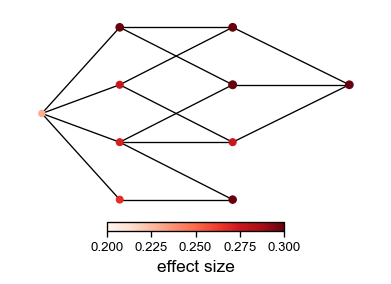

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 3))
nx.draw(
    dg,
    with_labels=False,
    ax=ax,
    pos=pos,
    arrows=False,
    node_size=node_size * 100,
    node_color=colors,
)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="Reds"),
    ax=ax,
    fraction=0.04,
    orientation="horizontal",
    pad=0.02,
)
cbar.ax.set_xlabel("effect size")
fig.savefig(
    "data/cwas-results/example-coding-categories-effect-sizes.png", bbox_inches="tight"
)

In [ ]:
node_level_df.query("level == 3")

,level,y,effect_size
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding,3,0.75,0.332592


# Try UMAP and tsne

I'm pretty sure I already did this, but whatever

In [71]:
data = category_svs[
    (category_svs["disease"] == "neuroblastoma")
    & (category_svs["sv_category"] == "noncoding")
]
data = data[data["category"].isin(framework_results["category_name"].sort_values().tolist())]

data = data.pivot(columns="SV", index="category", values="value").fillna(0)
data_values = data.values.astype(bool)

In [72]:
data_values.shape

(5679, 21743)

In [73]:
sparse_data_values = scipy.sparse.csr_matrix(data_values)

In [74]:
sparse_data_values

<5679x21743 sparse matrix of type '<class 'numpy.bool_'>'
	with 1030196 stored elements in Compressed Sparse Row format>

In [75]:
pca = PCA(n_components=50)  # Reduce to 2 components as an example
X_pca = pca.fit_transform(sparse_data_values.todense())

In [76]:
import umap.umap_ as umap  # NOTE: must install umap-learn not umap

In [77]:
np.random.seed(1)
umap_random_state = np.random.RandomState(1)

# run umap
umap_model = umap.UMAP(
    random_state=umap_random_state,
    metric="jaccard",
    verbose=True,
    min_dist=0.2,
    n_neighbors=50,
)
umap_result = umap_model.fit_transform(sparse_data_values)

# reformat the result into a dataframe
umap_plot_df = pd.DataFrame(umap_result, columns=["umap_x", "umap_y"], index=data.index)
umap_plot_df.index.name = "category_name"
umap_plot_df = umap_plot_df.reset_index()

UMAP(angular_rp_forest=True, metric='jaccard', min_dist=0.2, n_neighbors=50, random_state=RandomState(MT19937) at 0x7FA1C1976E40, verbose=True)
Sat Mar  2 17:02:10 2024 Construct fuzzy simplicial set
Sat Mar  2 17:02:10 2024 Finding Nearest Neighbors
Sat Mar  2 17:02:10 2024 Building RP forest with 9 trees
Sat Mar  2 17:02:10 2024 metric NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Sat Mar  2 17:02:27 2024 Finished Nearest Neighbor Search
Disconnection_distance = 1 has removed 12 edges.  This is not a problem as no vertices were disconnected.
Sat Mar  2 17:02:28 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Mar  2 17:02:39 2024 Finished embedding


In [78]:
umap_plot_df["disease"] = "neuroblastoma"
combined_df = master_framework_results.merge(
    umap_plot_df, on=["category_name", "disease"], how="right"
).set_index("category_name")
combined_df = combined_df.loc[umap_plot_df["category_name"]]

In [79]:
# Initialize t-SNE
tsne = TSNE(perplexity=50, n_components=2, random_state=2)

# Apply t-SNE on the binary matrix
X_embedded = tsne.fit_transform(X_pca)

In [123]:
combined_df["tsne_x"] = X_embedded[:, 0]
combined_df["tsne_y"] = X_embedded[:, 1]

centroid = combined_df[['tsne_x', 'tsne_y']].mean()

combined_df[['tsne_x', 'tsne_y']] = combined_df[['tsne_x', 'tsne_y']] - centroid

# rotate a tad
theta = 210 / 360 * 2 * np.pi
rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

combined_df[['tsne_x', 'tsne_y']] = np.dot(combined_df[['tsne_x', 'tsne_y']].values, rot_matrix)

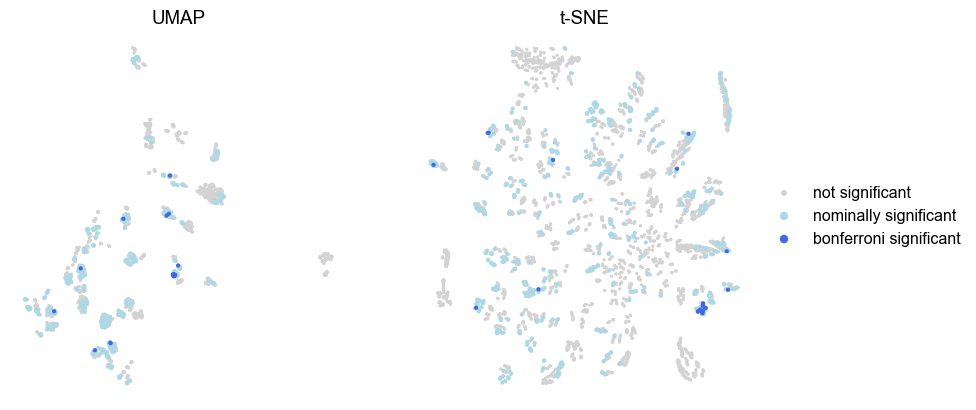

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, algo in enumerate(["umap", "tsne"]):
    ax = axes[i]

    x = f"{algo}_x"
    y = f"{algo}_y"

    sns.scatterplot(
        x=x,
        y=y,
        data=combined_df.query("negative_log10_p_value < 1.5"),
        ec=None,
        s=5,
        color="lightgrey",
        label="not significant",
        ax=ax,
    )

    plotted_data = combined_df.query("negative_log10_p_value > 1.5")
    sns.scatterplot(
        x=x,
        y=y,
        data=plotted_data.query("bonferroni_significant == False"),
        ec=None,
        s=10,
        color="lightblue",
        label="nominally significant",
        ax=ax,
    )

    sns.scatterplot(
        x=x,
        y=y,
        data=plotted_data.query("bonferroni_significant == True"),
        ec=None,
        s=10,
        color="royalblue",
        label="bonferroni significant",
        ax=ax,
    )

    if i == 1:
        ax.legend(bbox_to_anchor=(1, 0.5), markerscale=2)
    else:
        ax.legend().remove()

    ax.set_title(["UMAP", "t-SNE"][i])
    aesthetics.strip_axis(ax)

In [125]:
purple = '#9D4DAD'
bonf = -np.log10(0.05 / 940)
custom_cmap = colors.LinearSegmentedColormap.from_list('custom_purple', ['gainsboro', purple], N = 256)
norm = mpl.colors.Normalize(
        vmin=0,
        vmax=5,
    )

In [126]:
mpl.colors.to_hex(custom_cmap(norm(5)))

'#9d4dad'

In [127]:
0.05 / 940

5.3191489361702134e-05

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

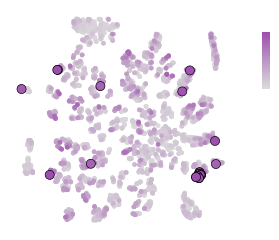

In [128]:
bonf = -np.log10(0.05 / 940)

fig, ax = plt.subplots(1, figsize=(3, 3))
    
data = combined_df.sort_values(by = 'negative_log10_p_value', ascending = True)

index = 0
while index < len(data):
    
    subdata = data.iloc[index:index + 200, :]
    sizes = subdata['bonferroni_significant'].fillna(False).replace({False: 2, True: 4})
    linewidths = subdata['bonferroni_significant'].fillna(False).replace({False: 0, True: 0.5})
    edgecolors = subdata['bonferroni_significant'].fillna(False).replace({False: 'none', True: 'black'})
    
    points = sns.scatterplot(
        x="tsne_x",
        y="tsne_y",
        data=subdata,
        ec=edgecolors,
        hue='negative_log10_p_value',
        hue_norm = norm,
        size= sizes,
        linewidth=linewidths,
        palette=custom_cmap,
        ax=ax,
        label=''
    )
    
    index += 200

ax.legend().remove()

# add the colorbar
cb = matplotlib.cm.ScalarMappable(norm=norm, cmap=custom_cmap)

cbar_ax = fig.add_axes([1, 0.6, 0.03, 0.2])
cbar = fig.colorbar(cb, cax=cbar_ax, orientation='vertical')

cbar.ax.tick_params(size=0)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)

aesthetics.strip_axis(ax)

In [131]:
combined_df.sort_values(by = 'tsne_y', ascending = False).head(20)[['point_estimate', 'tsne_x', 'tsne_y']]

,point_estimate,tsne_x,tsne_y
category_name,,,
CPX_or_INV.RARE.ANY.neuroblastoma_chromHMM15_Enh.ANY.ANY.ANY.protein_coding,0.088404,-36.678632,70.140057
ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_chromHMM15_EnhG.ANY.ANY.ANY.protein_coding,0.040914,-14.487136,70.057569
ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_chromHMM15_EnhG.ANY.ANY.expressed_in_adrenal_gland.protein_coding,-0.056640,-14.458119,70.032213
CPX_or_INV.RARE.ANY.neuroblastoma_chromHMM15_Enh.ANY.ANY.expressed_in_adrenal_gland.protein_coding,0.063067,-36.510776,69.992133
CPX_or_INV.SINGLETON.ANY.neuroblastoma_chromHMM15_Enh.ANY.ANY.ANY.protein_coding,0.431219,-35.747422,69.926209
ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_chromHMM15_EnhG_conserved.ANY.ANY.ANY.protein_coding,-0.008322,-20.687413,69.893584
CPX_or_INV.RARE.ANY.recombination_hotspot.ANY.ANY.ANY.protein_coding,-0.261980,-28.290447,69.892055
ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_chromHMM15_EnhG_conserved.ANY.ANY.expressed_in_adrenal_gland.protein_coding,0.145916,-20.680855,69.891463
CPX_or_INV.RARE.PREDICTED_NONCODING_SPAN.recombination_hotspot.ANY.ANY.ANY.protein_coding,-0.548243,-28.237305,69.834121


In [87]:
fig.savefig("images/tsne-neuroblastoma-noncoding.pdf", bbox_to_inches="tight")

## Try it with the permuted test statistics


In [661]:
permuted_test_nbl_noncoding = pd.read_csv(
    "data/CWAS data for Jett/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_permuted_z_score_matrix_12_26_23.txt",
    sep="\t",
    header=None,
)
permuted_test_nbl_noncoding.columns = ["category"] + list(range(1000))
permuted_test_nbl_noncoding = permuted_test_nbl_noncoding.dropna(
    subset=list(range(1000))
)

# drop those not present in our results
permuted_test_nbl_noncoding = permuted_test_nbl_noncoding[
    permuted_test_nbl_noncoding["category"].isin(
        framework_results["category_name"].tolist()
    )
]
permuted_test_nbl_noncoding = permuted_test_nbl_noncoding.set_index("category")
permuted_test_nbl_noncoding.shape

(5673, 1000)

In [705]:
zscore_corr = permuted_test_nbl_noncoding.T.corr()

In [728]:
eigenvalues, eigenvectors = np.linalg.eigh(zscore_corr.values)
eigenvalues[eigenvalues < 0] = 0
total_var = eigenvalues.sum()
var_explained = np.cumsum(eigenvalues) / total_var

# get the top 50 eigenvectors, drop the highest
top_eigenvectors = eigenvectors[:, -51:-1]

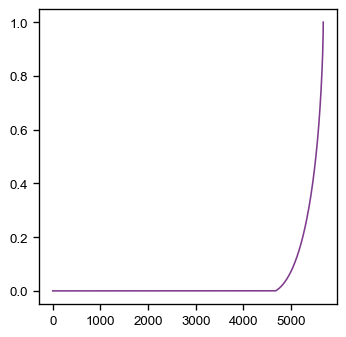

In [738]:
plt.plot(var_explained)

In [739]:
# Calculate the L2 norm of each row
l2_norms = np.linalg.norm(top_eigenvectors, axis=1, keepdims=True)

top_eigenvectors_norm = top_eigenvectors / l2_norms

Uhhhhhhhhh

In [741]:
# pca = PCA(n_components=50)
# X_pca = pca.fit_transform(permuted_test_nbl_noncoding.values)

In [742]:
np.random.seed(0)
umap_random_state = np.random.RandomState(0)

# run umap
umap_model = umap.UMAP(
    random_state=umap_random_state,
    metric="euclidean",
    verbose=True,
    min_dist=0.1,
    n_neighbors=10,
)
umap_result = umap_model.fit_transform(top_eigenvectors_norm)

# reformat the result into a dataframe
umap_plot_df = pd.DataFrame(
    umap_result, columns=["umap_x", "umap_y"], index=permuted_test_nbl_noncoding.index
)
umap_plot_df.index.name = "category_name"
umap_plot_df = umap_plot_df.reset_index()

umap_plot_df["disease"] = "neuroblastoma"
combined_df = framework_results.merge(
    umap_plot_df, on=["category_name", "disease"], how="right"
).set_index("category_name")
combined_df = combined_df.loc[umap_plot_df["category_name"]]

UMAP(n_neighbors=10, random_state=RandomState(MT19937) at 0x7FCB71C18640, verbose=True)
Sun Feb 11 17:44:59 2024 Construct fuzzy simplicial set
Sun Feb 11 17:44:59 2024 Finding Nearest Neighbors
Sun Feb 11 17:44:59 2024 Building RP forest with 9 trees
Sun Feb 11 17:44:59 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	Stopping threshold met -- exiting after 7 iterations
Sun Feb 11 17:44:59 2024 Finished Nearest Neighbor Search
Sun Feb 11 17:44:59 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sun Feb 11 17:45:06 2024 Finished embedding


In [745]:
# Apply t-SNE
tsne = TSNE(perplexity=50, n_components=2, random_state=0)
X_tsne = tsne.fit_transform(top_eigenvectors_norm)

In [746]:
combined_df["tsne_x"] = X_tsne[:, 0]
combined_df["tsne_y"] = X_tsne[:, 1]

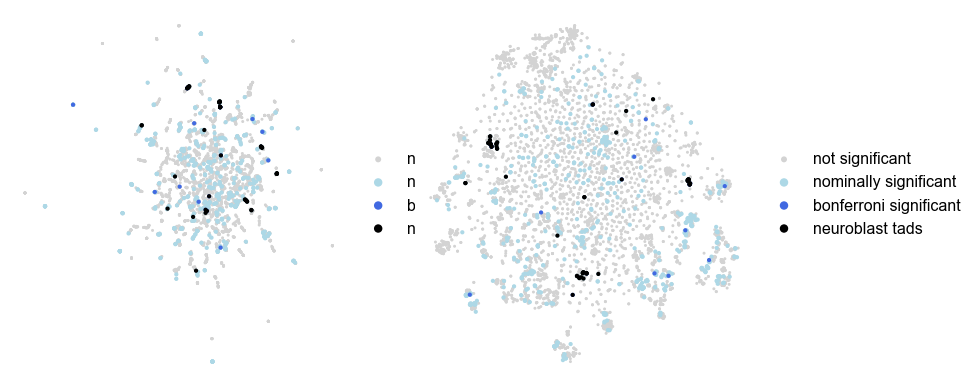

In [750]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, algo in enumerate(["umap", "tsne"]):
    ax = axes[i]

    x = f"{algo}_x"
    y = f"{algo}_y"

    sns.scatterplot(
        x=x,
        y=y,
        data=combined_df.query("negative_log10_p_value < 1.5"),
        ec=None,
        s=5,
        color="lightgrey",
        label="not significant",
        ax=ax,
    )

    plotted_data = combined_df.query("negative_log10_p_value > 1.5")
    sns.scatterplot(
        x=x,
        y=y,
        data=plotted_data.query("bonferroni_significant == False"),
        ec=None,
        s=10,
        color="lightblue",
        label="nominally significant",
        ax=ax,
    )

    sns.scatterplot(
        x=x,
        y=y,
        data=plotted_data.query("bonferroni_significant == True"),
        ec=None,
        s=10,
        color="royalblue",
        label="bonferroni significant",
        ax=ax,
    )

    sns.scatterplot(
        x=x,
        y=y,
        data=plotted_data.query("functional_category == 'neuroblastoma_tad_boundary'"),
        ec=None,
        s=10,
        color="black",
        label="neuroblast tads",
        ax=ax,
    )

    ax.legend(bbox_to_anchor=(1, 0.5), markerscale=2)
    aesthetics.strip_axis(ax)